In [1]:
# Things to be included
# 1. visualization tools for optimization
# 2. visualization tools for plotting actual and predicted sequence, and anomaly points
# 3. Computation cost calculation
# 4. Warnings / Errors?

In [2]:
import numpy as np
from numpy import array
import random
from random import randint
import os
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.model_selection
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout
from keras.optimizers import SGD
import pdb

In [3]:
#model will be trained on GPU 1, I don't need it now.
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [103]:
def anomaly_detector(prediction_seq, ground_truth_seq):
    
    """ Anomaly detector
    
    This is the method to determin whether this is an anomaly outlier.
    Enclidean distance is used to calculate the number here.
    
    parameter
    ----
    prediction_seq: list.
    ground_truth_seq: array.
    
    return
    ----
    final_list: array of boolean.
    
    """
    # calculate Euclidean between actual seq and predicted seq
    if len(prediction_seq) != len(ground_truth_seq):
        print("Error! You did not have same length of sequence!")
        return
    else:
        final_list = []
        for i in range(len(prediction_seq)):
            dist = np.linalg.norm(ground_truth_seq[i][0] - prediction_seq[i])
            if (abs(dist) > anm_det_thr):
                final_list.append(True)  # anomaly
            else:
                final_list.append(False) # normal
        return np.array(final_list)

In [67]:
"""Hyperparameters

List down all the hyperparamters and the explianation.
"""

w = 10                 # History window (number of time stamps taken into account) 
                         # i.e., filter(kernel) size       
p_w = 1                # Prediction window (number of time stampes required to be 
                         # predicted)
n_features = 1           # Univariate time series

kernel_size = 2          # Size of filter in conv layers
num_filt_1 = 32          # Number of filters in first conv layer
num_filt_2 = 32          # Number of filters in second conv layer
num_nrn_dl = 40          # Number of neurons in dense layer
num_nrn_ol = p_w         # Number of neurons in output layer

conv_strides = 1
pool_size_1 = 2          # Length of window of pooling layer 1
pool_size_2 = 2          # Length of window of pooling layer 2
pool_strides_1 = 2       # Stride of window of pooling layer 1
pool_strides_2 = 2       # Stride of window of pooling layer 2

epochs = 30
dropout_rate = 0.5       # Dropout rate in the fully connected layer
learning_rate = 0.01  
anm_det_thr = 0.5        # Threshold for classifying anomaly (0.5~0.8)

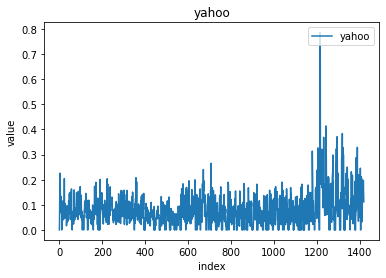

<Figure size 7200x720 with 0 Axes>

   timestamp     value  is_anomaly
0          1  0.000000           0
1          2  0.091758           0
2          3  0.172297           0
3          4  0.226219           0
4          5  0.176358           0


,timestamp,value
0,1,0.000000
1,2,0.116573
2,3,0.218893
3,4,0.287399
4,5,0.224053


In [68]:
"""Data loading

Load the data and normalize the value.
Separate the is_anomaly data out from the dataset.
Plot the overview of the dataset
"""

yahoo = pd.read_csv('/Users/fermat/Desktop/RIT_Class/2021 Spring/Data_Science_project/paper_dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_1.csv')
plt.plot(yahoo['value'])
plt.title('yahoo')
plt.ylabel('value')
plt.xlabel('index')
plt.legend(['yahoo'], loc='upper right')
plt.figure(figsize=(100,10))
plt.show()
print(yahoo.head())
norm_data = list(yahoo['value'])
yahoo['value'] = [(float(i)-min(norm_data))/(max(norm_data)-min(norm_data)) for i in norm_data]
true_label = yahoo['is_anomaly'].copy()
yahoo = yahoo.drop(columns=['is_anomaly'])
yahoo.head()


In [69]:
"""Data preprocessing"""

# split a univariate sequence into samples
def split_sequence(sequence):
    X, y = [], []
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + w
        out_end_ix = end_ix + p_w
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
        
    return array(X), array(y)
      

# define input sequence
raw_seq = list(yahoo['value'])

# split into samples
batch_sample, batch_label = split_sequence(raw_seq)
print(batch_sample)
print(batch_sample.shape)

# split into train and test
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(batch_sample,batch_label,test_size=0.2,random_state=42)
  
# 2. reshape from [samples, timesteps] into [samples, timesteps, features]

# need to convert batch into 3D tensor of the form [batch_size, input_seq_len, n_features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
batch_sample = batch_sample.reshape((batch_sample.shape[0], batch_sample.shape[1], n_features))

[[0.         0.11657333 0.21889332 ... 0.08693264 0.16935357 0.10802149]
 [0.11657333 0.21889332 0.28739895 ... 0.16935357 0.10802149 0.12332587]
 [0.21889332 0.28739895 0.22405289 ... 0.10802149 0.12332587 0.        ]
 ...
 [0.05579008 0.06745122 0.26040117 ... 0.22281139 0.20285787 0.17484625]
 [0.06745122 0.26040117 0.04549539 ... 0.20285787 0.17484625 0.25083827]
 [0.26040117 0.04549539 0.04189874 ... 0.17484625 0.25083827 0.20576891]]
(1410, 10)


In [77]:
"""Generate model for predictor"""
model = Sequential()

# Convolutional Layer #1
# Computes 32 features using a 1D filter(kernel) of with w with ReLU activation. 
# Padding is added to preserve width.
# Input Tensor Shape: [batch_size, w, 1] / batch_size = len(batch_sample)
# Output Tensor Shape: [batch_size, w, num_filt_1] (num_filt_1 = 32 feature vectors)
model.add(Conv1D(filters=num_filt_1,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu',
                 input_shape=(w, n_features)))

# Pooling Layer #1
# First max pooling layer with a filter of length 2 and stride of 2
# Input Tensor Shape: [batch_size, w, num_filt_1]
# Output Tensor Shape: [batch_size, 0.5 * w, num_filt_1]

model.add(MaxPooling1D(pool_size=pool_size_1)) 
                    #  strides=pool_strides_1, 
                    #  padding='valid'))

# Convolutional Layer #2
# Computes 64 features using a 5x5 filter.
# Padding is added to preserve width and height.
# Input Tensor Shape: [batch_size, 0.5 * w, 32]
# Output Tensor Shape: [batch_size, 0.5 * w, num_filt_1 * num_filt_2]
model.add(Conv1D(filters=num_filt_2,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))

# Max Pooling Layer #2
# Second max pooling layer with a 2x2 filter and stride of 2
# Input Tensor Shape: [batch_size, 0.5 * w, num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 0.25 * w, num_filt_1 * num_filt_2]
model.add(MaxPooling1D(pool_size=pool_size_2))
                    #  strides=pool_strides_2, 
                    #  padding='valid'
          
# Flatten tensor into a batch of vectors
# Input Tensor Shape: [batch_size, 0.25 * w, num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 0.25 * w * num_filt_1 * num_filt_2]
model.add(Flatten())

# Dense Layer (Output layer)
# Densely connected layer with 1024 neurons
# Input Tensor Shape: [batch_size, 0.25 * w * num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 1024]
model.add(Dense(units=num_nrn_dl, activation='relu'))  

# Dropout
# Prevents overfitting in deep neural networks
model.add(Dropout(dropout_rate))

# Output layer
# Input Tensor Shape: [batch_size, 1024]
# Output Tensor Shape: [batch_size, p_w]
model.add(Dense(units=num_nrn_ol))

# Summarize model structure
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 4, 32)             0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 3, 32)             2080      
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 1, 32)             0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 40)                1320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 40)               

In [78]:
'''configure model'''
# model.compile(optimizer='adam', 
#               loss='mean_squared_error',
#               metrics=['accuracy'])
# should use mean_absolute_error

sgd = keras.optimizers.SGD(lr=learning_rate, 
                         decay=1e-6, 
                         momentum=0.9, 
                         nesterov=True)
model.compile(optimizer='sgd', 
              loss='mean_absolute_error', 
              metrics=['accuracy'])

In [79]:
'''Training'''
model_fit = model.fit(batch_sample,
                      batch_label,
                      epochs=epochs,
                      verbose=1)

Epoch 1/30
45/45 [==============================] - 0s 2ms/step - loss: 0.0619 - accuracy: 0.1007
Epoch 2/30
45/45 [==============================] - 0s 2ms/step - loss: 0.0564 - accuracy: 0.1007
Epoch 3/30
45/45 [==============================] - 0s 2ms/step - loss: 0.0563 - accuracy: 0.1007
Epoch 4/30
45/45 [==============================] - 0s 2ms/step - loss: 0.0558 - accuracy: 0.1007
Epoch 5/30
45/45 [==============================] - 0s 2ms/step - loss: 0.0558 - accuracy: 0.1007
Epoch 6/30
45/45 [==============================] - 0s 2ms/step - loss: 0.0558 - accuracy: 0.1007
Epoch 7/30
45/45 [==============================] - 0s 2ms/step - loss: 0.0556 - accuracy: 0.1007
Epoch 8/30
45/45 [==============================] - 0s 2ms/step - loss: 0.0556 - accuracy: 0.1007
Epoch 9/30
45/45 [==============================] - 0s 2ms/step - loss: 0.0556 - accuracy: 0.1007
Epoch 10/30
45/45 [==============================] - 0s 2ms/step - loss: 0.0557 - accuracy: 0.1007
Epoch 11/30
45/45 [

In [80]:
"""Save Weights (DeepAnT)"""
# save it to disk so we can load it back up anytime
model.save_weights('yahoo_DeepAnT.h5')

In [81]:
"""Testing with random interval(DeepAnT)"""
# Set number of test sequences 
n_test_seq = 20

# Split a univariate sequence into samples
def generate_test_batch(raw_seq, n_test_seq):
  # Sample a portion of the raw_seq randomly
    ran_ix = random.randint(0,len(raw_seq) - n_test_seq * w - n_test_seq * p_w)
    raw_test_seq = array(raw_seq[ran_ix:ran_ix + n_test_seq * w +  n_test_seq * p_w])
    batch_test_seq, batch_test_label = list(), list()
    ix = ran_ix
    for i in range(n_test_seq):
        # gather input and output parts of the pattern
        seq_x = raw_seq[ix : ix+w],
        seq_y = raw_seq[ix+w : ix+w+p_w]
        ix = ix+w+p_w
        batch_test_seq.append(seq_x)
        batch_test_label.append(seq_y)
    return array(batch_test_seq), array(batch_test_label)

batch_test_seq, batch_test_label = generate_test_batch(list(yahoo['value']), n_test_seq)
batch_test_seq = batch_test_seq.reshape((batch_test_seq.shape[0], w, n_features))
batch_test_label = batch_test_label.reshape((batch_test_label.shape[0], p_w))

# Returns the loss value & metrics values for the model in test mode
model.evaluate(x=batch_test_seq,
               y=batch_test_label,
               verbose=1)

1/1 [==============================] - 0s 2ms/step - loss: 0.0483 - accuracy: 0.0500


[0.04826414957642555, 0.05000000074505806]

In [82]:
"""Predicting random intervals (DeepAnT)"""
# Build model 
model = Sequential()
model.add(Conv1D(filters=num_filt_1,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu',
                 input_shape=(w, n_features)))
model.add(MaxPooling1D(pool_size=pool_size_1)) 
model.add(Conv1D(filters=num_filt_2,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=pool_size_2))
model.add(Flatten())
model.add(Dense(units=num_nrn_dl, activation='relu')) 
model.add(Dropout(dropout_rate))
model.add(Dense(units=num_nrn_ol))

# Load the model's saved weights.
model.load_weights('aws_DeepAnT.h5')
          
# Sample a portion of the raw_seq randomly
# 1. Choose 
ran_ix = random.randint(1,len(raw_seq) - w - p_w)
input_seq = array(raw_seq[ran_ix : ran_ix + w])
target_seq = array(raw_seq[ran_ix + w : ran_ix + w + p_w])
input_seq = input_seq.reshape((1, w, n_features))

# Predict the next time stampes of the sampled sequence
yhat = model.predict(input_seq, verbose=1)

# Print our model's predictions.
print(yhat)

# Check our predictions against the ground truths.
print(target_seq) # [7, 2, 1, 0, 4]

1/1 [==============================] - 0s 2ms/step
[[0.09918661]]
[0.06493398]


In [83]:
"""Predicting the whole sequence (DeepAnT)"""
# Build model 
model = Sequential()
model.add(Conv1D(filters=num_filt_1,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu',
                 input_shape=(w, n_features)))
model.add(MaxPooling1D(pool_size=pool_size_1)) 
model.add(Conv1D(filters=num_filt_2,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=pool_size_2))
model.add(Flatten())
model.add(Dense(units=num_nrn_dl, activation='relu')) 
model.add(Dropout(dropout_rate))
model.add(Dense(units=num_nrn_ol))

# Load the model's saved weights.
model.load_weights('aws_DeepAnT.h5')
          

input_seq = batch_sample.copy()
target_seq = batch_label.copy()
predicted_seq = []
for i in range(len(input_seq)):
    input = input_seq[i]
    input = input.reshape((1, w, n_features))
    t = model.predict(input, verbose=1)[0][0]
    predicted_seq.append(t)
# Predict the next time stampes of the sampled sequence


# Print our model's predictions.
print(predicted_seq)

# Check our predictions against the ground truths.
print(target_seq) # [7, 2, 1, 0, 4]

1/1 [==============================] - 0s 3ms/step
[0.18548883, 0.18869057, 0.1473094, 0.14880583, 0.11070508, 0.108033165, 0.107479624, 0.1122799, 0.11345, 0.11770729, 0.10838834, 0.09939857, 0.11397256, 0.098079726, 0.11724435, 0.10352068, 0.09509124, 0.106309325, 0.12030283, 0.11612896, 0.1353311, 0.13713433, 0.10424185, 0.1216441, 0.10048144, 0.11870049, 0.1139107, 0.11665053, 0.111520186, 0.12217029, 0.11303477, 0.11063506, 0.1104558, 0.10632656, 0.090955764, 0.10955094, 0.10175659, 0.09832585, 0.10963425, 0.10476935, 0.091430515, 0.11308765, 0.109997205, 0.117492095, 0.11550898, 0.1222438, 0.10277427, 0.11287633, 0.112321824, 0.10351295, 0.117424846, 0.10894793, 0.11397888, 0.12109431, 0.12266518, 0.117434494, 0.11672718, 0.11200927, 0.119561106, 0.10397394, 0.11901476, 0.09577322, 0.10764439, 0.10066184, 0.112567924, 0.12431606, 0.11657538, 0.1201427, 0.11765191, 0.11016275, 0.1161256, 0.10744381, 0.10985187, 0.11424201, 0.10648919, 0.10882701, 0.11097163, 0.11338827, 0.11810116

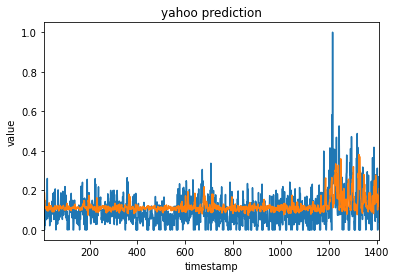

<Figure size 7200x720 with 0 Axes>

In [87]:
'''Visualization of predicted time series'''
# in_seq = yahoo['value'][endix:endix+w]

# tar_seq = yahoo['value'][endix+w:endix+w+p_w]
tar_seq = yahoo['value'][w:]
# predicted_seq = predicted_seq.reshape((p_w))
# d = {'timestamp': yahoo['timestamp'][endix+w:endix+w+p_w], 'values': predicted_seq}
d = {'timestamp': yahoo['timestamp'][w:], 'values': predicted_seq}
yahoo_pre = pd.DataFrame(data=d)
pre_seq = yahoo_pre['values']

# plt.plot(in_seq)
plt.plot(tar_seq)
plt.plot(pre_seq)
plt.title('yahoo prediction')
plt.ylabel('value')
plt.xlabel('timestamp')
# plt.legend(['input_seq', 'target_seq', 'pre_seq'], loc='upper right')
axes = plt.gca()
# axes.set_xlim([endix,endix+w+p_w])
# axes.set_xlim([11,4033])
axes.set_xlim([w,len(predicted_seq)])
fig_predict = plt.figure(figsize=(100,10))
# fig_predict.savefig('predicted_sequence.png')
plt.show()